In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from pyesm.measures import find_min_angle, find_min_MSE, spectral_angle, ordered_mse
from pathlib import Path
import matplotlib.pyplot as plt
import re
import numpy as np
import hyperspy.api as hs
from pyesm.measures import KLdiv_loss
from pyesm.models.edxs import G_EDXS
from experiments.conf import RESULTS_PATH

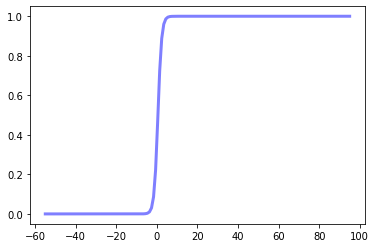

In [6]:
x =  np.linspace(-55,95,num=150)
def sigmoid(x,mi, mx): 
    return mi + (mx-mi)*(lambda t: (1+3**(-t+0.5))**(-1) )( (x-mi)/(mx-mi) )
h = (x,-0.5,0.5)

plt.plot(x, sigmoid(x, 0, 1),'b-', lw=3, alpha=0.5, label='sigmoid')

h = sigmoid(x,0,1)

res = h[:,np.newaxis]@np.ones((1,200))

In [66]:
b  = np.zeros((2,150,200))
b[0,:] = res
b[1,:] = (1-res)

In [7]:
f1 = hs.load("1613NLNO_binned_2_film_avg.hspy")
f2 = hs.load("1613NLNO_binned_2_substrate_avg.hspy")
# f3 = hs.load("1613NLNO_binned_shit_avg.hspy")
scale = f1.axes_manager[0].scale
offset = f1.axes_manager[0].offset
size = f1.axes_manager[0].size
x = np.linspace(offset,offset + size*scale, num = size)


true_spectra = np.array([f1.data,f2.data])#,f3.data])#,f1.data])

# Load data and ground truth

In [15]:
file = "1613_NLNO_binned_2_random_rs0_fwjs_2comps_mu10_l10.npz"
path = RESULTS_PATH / Path(file)
data = np.load(path)
spim = hs.load("1613_NLNO_binned_2.hspy")
shape_2d = spim.shape_2d
k = 2
G = data["G"]
W = data["W"]
GW = G@W
H = data["H"]

angles, true_ind_spec = find_min_angle(true_spectra,corrected_res,unique = True, get_ind=True)
# maps = find_min_MSE(b,H,unique = True)

In [56]:
res_maps = np.zeros_like(b)
res_maps[0,:,:] = H[0].reshape(150,200)
res_maps[1,:,:] = H[1].reshape(150,200)

In [64]:
d = {}
d["true_maps_0"] = b[0]
d["true_maps_1"] = b[1]
d["x"] = x
d["true_spectra_0"] = true_spectra[0]
d["true_spectra_1"] = true_spectra[1]
d["res_spectra_0"] = GW[:,0]
d["res_spectra_1"] = GW[:,1]
d["res_maps_0"] = res_maps[0]
d["res_maps_1"] = res_maps[1]
d["corrected_spectra_0"] = corrected_res[0]
d["corrected_spectra_1"] = corrected_res[1]

np.savez("experimental_results.npz",**d)

## Plot params

In [48]:
fontsize = 30
scale = 15
aspect_ratio = 1.4
marker_list = ["-o","-s","->","-<","-^","-v","-d"]
mark_space = 20


# Plot spectra and maps

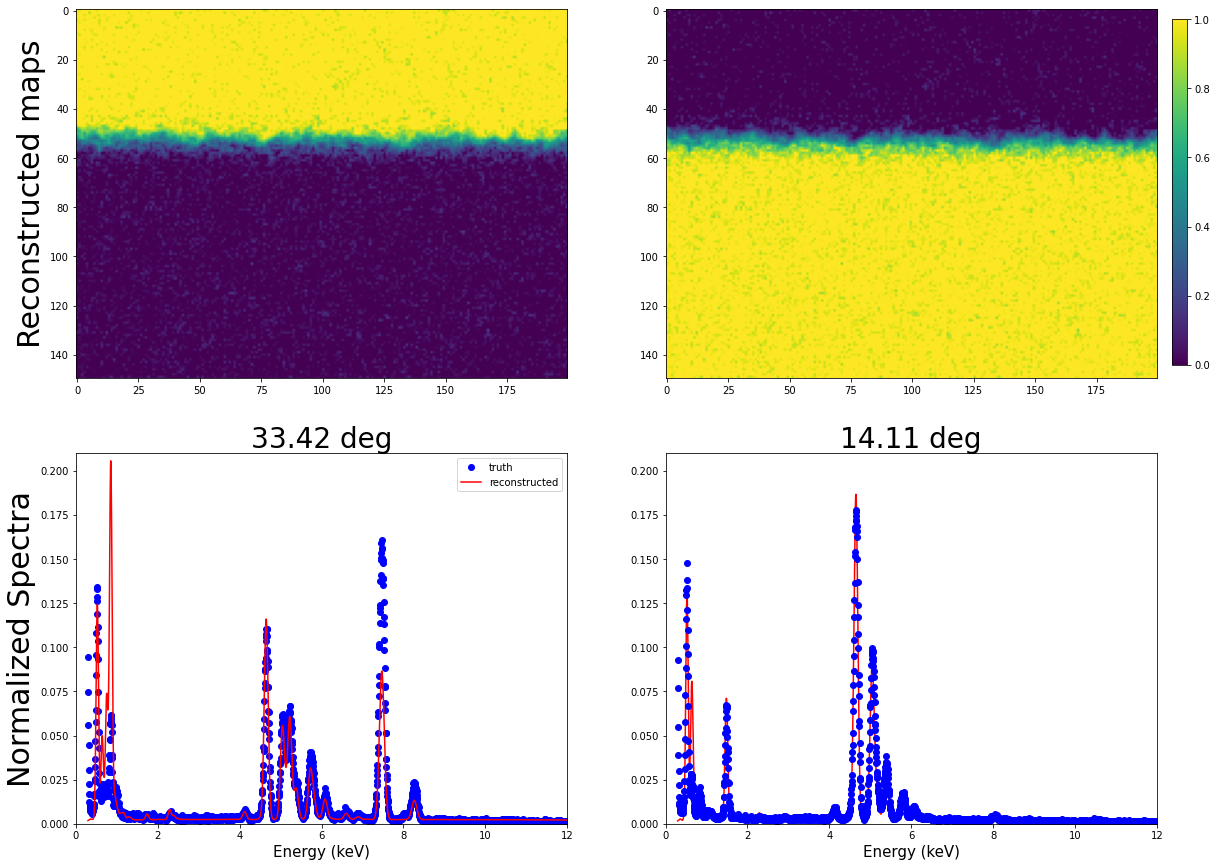

In [40]:
fig, axes = plt.subplots(2,k,figsize = (scale/k * 2 * aspect_ratio,scale))
# fig.suptitle("{} : {}".format(file,KLdiv_loss(X,GP,A)), fontsize=32)
for i, spectre in enumerate(true_spectra): 
    axes[1,i].plot(x,true_spectra[i],'bo',label='truth',linewidth=4)
    axes[1,true_ind_spec[i]].plot(x,GW.T[i] ,'r-',label='reconstructed',markersize=3.5)
    axes[1,true_ind_spec[i]].set_title("{:.2f} deg".format(angles[i]),fontsize = fontsize-2)
    axes[1,i].set_xlim(0,12)
    axes[1,i].set_ylim(0.0,0.21)
    axes[1,i].set_xlabel("Energy (keV)",fontsize = fontsize/2)

    im = axes[0,true_ind_spec[i]].imshow(H[i].reshape(shape_2d))#,vmin = 0.0, vmax = 1.0 )
    # axes[0,i].set_title("{:.2f} MSE".format(mse[i]),fontsize = fontsize-2)
    # axes[i,1].set_ylim(0.0,1.0)
    # axes[0,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)
    # axes[0,i].set_title("{}".format(labels[i]),fontsize = fontsize-2)
    axes[1,0].legend()

rows = ["Reconstructed maps","Normalized Spectra"]

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=fontsize)


fig.subplots_adjust(right=0.84)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.85, 0.55, 0.01, 0.32])
fig.colorbar(im,cax=cbar_ax)

# fig.tight_layout()

plt.show()

In [15]:
from pyesm.models.EDXS_function import print_concentrations_from_W

print_concentrations_from_W(W[:-2,:],elements=spim.metadata.Sample.elements)

Concentrations report
     p0     p1
O  : 0.2643 0.1908 
Al : 0.1519 0.0000 
Si : 0.0071 0.0057 
Mo : 0.0108 0.0113 
Ni : 0.0000 0.3751 
Nd : 0.0000 0.1591 
La : 0.5658 0.2580 
Cu : 0.0000 0.0000 


In [9]:
spim.metadata.xray_db = "NLNO_v2.json"
new_G = spim.build_G("bremsstrahlung",norm = False)
if callable(new_G) :
    new_G = new_G()[:,:-2]
else : 
    new_G = new_G[:,:-2]

film = true_spectra[0]
substrate = true_spectra[1]

new_W_film = np.abs(np.linalg.lstsq(new_G,film - G[:,8:]@W[8:,0],rcond = None)[0])
new_W_substrate = np.abs(np.linalg.lstsq(new_G,substrate - G[:,8:]@W[8:,1],rcond= None)[0])

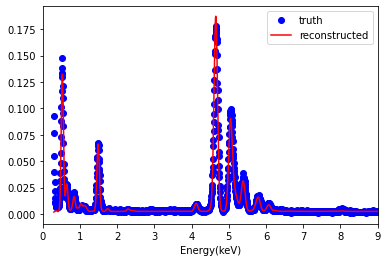

In [58]:

plt.plot(x,true_spectra[1],'bo',label='truth',linewidth=4)
plt.plot(x,new_G@new_W_substrate + G[:,8:]@W[8:,1],'r-',label='reconstructed',markersize=3.5 )
# plt.plot(film)
plt.xlim(0,9)
plt.xlabel("Energy(keV)")
plt.legend()

In [10]:
corrected_res = np.array([new_G@new_W_substrate + G[:,8:]@W[8:,1],new_G@new_W_film + G[:,8:]@W[8:,1]])

In [25]:
print_concentrations_from_W(new_W_film[:,np.newaxis],elements = spim.metadata.Sample.elements)

Concentrations report
     p0
O  : 0.3275 
Al : 0.0073 
Si : 0.0060 
Mo : 0.0070 
Ni : 0.4319 
Nd : 0.1473 
La : 0.0694 
Cu : 0.0037 


In [ ]:
fig, axes = plt.subplots(2,k,figsize = (scale/k * 3 * aspect_ratio,scale))
fig.subplots_adjust(wspace=0.01,hspace=0.01)



for i, spectre in enumerate(true_spectra): 
    # axes[1,i].plot(true_spectra[i],'bo',label='truth',linewidth=4)
    # axes[1,i].plot(GP.T[true_ind_spec[i]] ,'r-',label='reconstructed',markersize=3.5)
    # axes[1,i].set_title("{:.2f} deg".format(angles[i]),fontsize = fontsize-2)
    # axes[1,i].set_xlim(0,1000)

    axes[1,i].imshow(A[true_ind_spec[i]].reshape(shape_2d),vmin = 0.0, vmax = 1.0 )
    axes[1,i].set_title("{:.2f} MSE".format(mse[i]),fontsize = fontsize-2)
    axes[1,i].tick_params(axis=u'both', which=u'both',length=0)
    axes[1,i].set_xticklabels([])
    axes[1,i].set_yticklabels([])
    # axes[i,1].set_ylim(0.0,1.0)

    im = axes[0,i].imshow(true_maps[i].reshape(shape_2d),vmin = 0.0, vmax = 1.0)
    axes[0,i].set_title("Phase {}".format(i),fontsize = fontsize)
    axes[0,i].tick_params(axis=u'both', which=u'both',length=0)
    axes[0,i].set_xticklabels([])
    axes[0,i].set_yticklabels([])

    # axes[2,0].legend()

rows = ["Truth","Reconstructed","Spectra"]

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=fontsize)


fig.subplots_adjust(right=0.84)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.3])
fig.colorbar(im,cax=cbar_ax)
cbar_ax.tick_params(labelsize=fontsize)

# fig.tight_layout()

plt.show()

# Plot losses

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(4*scale,scale))

names = list(losses.dtype.names)
for j,name in enumerate(names) :
    if re.match(r".*(loss)",name) : 
        axes[0].plot(losses[name],marker_list[j%len(marker_list)],markersize=3.5,label = name,markevery = mark_space,linewidth = 2)
        axes[0].set_yscale("log")
        axes[0].set_xscale("log")
        axes[0].tick_params(axis='both', which='major', labelsize=fontsize-5)
        axes[0].set_xscale("log")
        axes[0].legend(fontsize = fontsize -2)
        axes[0].set_xlabel("number of iterations",fontsize = fontsize -5)
    elif re.match(r"^(rel)",name) : 
        axes[1].plot(losses[name],marker_list[j%len(marker_list)],markersize=3.5,label = name,markevery = mark_space,linewidth = 2)
        axes[1].legend(fontsize = fontsize -2)
        axes[1].set_yscale("log")
        axes[1].set_xscale("log")
        axes[1].tick_params(axis='both', which='major', labelsize=fontsize-5)
        axes[1].set_xlabel("number of iterations",fontsize = fontsize -5)
    elif re.match(r"^(ang)",name) :
        axes[2].plot(losses[name],marker_list[j%len(marker_list)],markersize=3.5,label = name,markevery = mark_space,linewidth = 2)
        axes[2].legend(fontsize = fontsize -2)
        axes[2].set_xscale("log")
        axes[2].tick_params(axis='both', which='major', labelsize=fontsize-5)
        axes[2].set_xlabel("number of iterations",fontsize = fontsize -5)
    elif re.match(r"^(mse)",name) :
        axes[3].plot(losses[name],marker_list[j%len(marker_list)],markersize=3.5,label = name,markevery = mark_space,linewidth = 2)
        axes[3].legend(fontsize = fontsize -2)
        axes[3].set_xscale("log")
        axes[3].tick_params(axis='both', which='major', labelsize=fontsize-5)
        axes[3].set_xlabel("number of iterations",fontsize = fontsize -5)

# Without ground truth

In [ ]:
s = hs.load("B5IC1_binned.hspy")
s.axes_manager

In [ ]:
file = "B5IC1_nmf_noS.npz"
path = RESULTS_PATH / Path(file)
data = np.load(path)
shape_2d = (300,300)
k = 10
GP = data["D"]
A = data["A"]
# x = np.linspace(0.59765,0.59765 + 3880*0.005, num = 3880)
# x = np.linspace(0.81805,0.81805 + 1918*0.005, num = 1918)
# x = np.linspace(0.6996000000000001 ,0.6996000000000001  + 800*0.01, num = 800)
x = np.linspace(1.85058504, 1.85058504 + 0.010001*1805, num = 1805)
fontsize = 30
scale = 15
aspect_ratio = 1.4
marker_list = ["-o","-s","->","-<","-^","-v","-d"]
mark_space = 20

In [ ]:
plt.imshow(A[8].reshape(shape_2d),vmin = 0.0, vmax = 1.0, cmap = "Greys_r" )
plt.tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(2,k,figsize = (scale/k * 2 * aspect_ratio,scale))
fig.suptitle(file, fontsize=32)
for i in range(k): 
    # axes[1,i].plot(new_x_true,trunc_true[i]/np.max(trunc_true[i]),'bo',label='truth',linewidth=4)
    axes[1,i].plot(x,GP.T[i] ,'ro-',label='reconstructed',markersize=3.5,markevery = mark_space)
    # axes[1,i].set_title("{:.2f} deg".format(angles[i]),fontsize = fontsize-2)
#     axes[1,i].set_xlim(0,10)
    axes[1,i].set_xlabel("Energy (keV)",fontsize = fontsize/2)

    im = axes[0,i].imshow(A[i].reshape(shape_2d),vmin = 0.0, vmax = 1.0 )
    # axes[0,i].set_title("{:.2f} MSE".format(mse[i]),fontsize = fontsize-2)
    # axes[i,1].set_ylim(0.0,1.0)
    axes[0,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)
#     axes[0,i].set_title("{}".format(labels[i]),fontsize = fontsize-2)
    axes[1,0].legend()

rows = ["Reconstructed maps","Normalized Spectra"]

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=fontsize)


fig.subplots_adjust(right=0.84)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.85, 0.55, 0.01, 0.32])
fig.colorbar(im,cax=cbar_ax)

# fig.tight_layout()

plt.show()

In [ ]:
Xl = GP@A
Xl_sum = np.sum(Xl,axis = 1)
a_sum = np.sum(a.data,axis=(0,1))

In [ ]:
plt.plot(Xl_sum)
plt.plot(a_sum)
plt.plot(a_sum - Xl_sum)

In [ ]:
a = hs.load("71GPa_subsolidus.hspy")
a.axes_manager

In [ ]:
a = hs.load("1537_Robin_cropped.hspy")
a.change_dtype("float64")
a.decomposition(True,algorithm = "NMF",output_dimension = 3,solver = "mu",tol = 1e-4, max_iter = 1000)
k=3

In [ ]:
l = a.get_decomposition_loadings()
f = a.get_decomposition_factors()

In [ ]:
fig, axes = plt.subplots(2,k,figsize = (scale/k * 2 * aspect_ratio,scale))
fig.suptitle("HSPY NMF", fontsize=32)
for i in range(k): 
    # axes[1,i].plot(new_x_true,trunc_true[i]/np.max(trunc_true[i]),'bo',label='truth',linewidth=4)
    axes[1,i].plot(x,f.inav[i].data ,'ro-',label='reconstructed',markersize=3.5,markevery = mark_space)
    # axes[1,i].set_title("{:.2f} deg".format(angles[i]),fontsize = fontsize-2)
#     axes[1,i].set_xlim(0,10)
    axes[1,i].set_xlabel("Energy (keV)",fontsize = fontsize/2)

    im = axes[0,i].imshow(l.inav[i].data)#,vmin = 0.0, vmax = 1.0 )
    # axes[0,i].set_title("{:.2f} MSE".format(mse[i]),fontsize = fontsize-2)
    # axes[i,1].set_ylim(0.0,1.0)
    axes[0,i].tick_params(axis = "both",labelleft = False, labelbottom = False,left = False, bottom = False)
#     axes[0,i].set_title("{}".format(labels[i]),fontsize = fontsize-2)
    axes[1,0].legend()

rows = ["Reconstructed maps","Normalized Spectra"]

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=fontsize)


fig.subplots_adjust(right=0.84)
# put colorbar at desire position
cbar_ax = fig.add_axes([0.85, 0.55, 0.01, 0.32])
fig.colorbar(im,cax=cbar_ax)

# fig.tight_layout()

plt.show()